In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import sys
import re
import unicodedata



In [131]:
with open("kaggle_api_key.txt", "r", encoding="utf-8") as f:
    lines = [line.strip() for line in f.readlines()]

os.environ["KAGGLE_USERNAME"] = lines[0]
os.environ["KAGGLE_KEY"] = lines[1]

from kaggle import api

In [132]:
data_list = [
    "shivamb/netflix-shows",
    "shivamb/hulu-movies-and-tv-shows",
    "shivamb/disney-movies-and-tv-shows",
    "shivamb/amazon-prime-movies-and-tv-shows",
    "utkarshx27/movies-dataset",
    "ruchi798/tv-shows-on-netflix-prime-video-hulu-and-disney",
    "webdevbadger/streaming-service-prices",
]
python = f'"{sys.executable}"'

os.makedirs("data", exist_ok=True)

for source in data_list:
    api.dataset_download_files(
        source,
        path="data",
        unzip=True,
        quiet=False,
    )

Dataset URL: https://www.kaggle.com/datasets/shivamb/netflix-shows


100%|██████████| 1.34M/1.34M [00:00<00:00, 2.83MB/s]



Dataset URL: https://www.kaggle.com/datasets/shivamb/hulu-movies-and-tv-shows


100%|██████████| 421k/421k [00:00<00:00, 1.16MB/s]



Dataset URL: https://www.kaggle.com/datasets/shivamb/disney-movies-and-tv-shows


100%|██████████| 131k/131k [00:00<00:00, 713kB/s]



Dataset URL: https://www.kaggle.com/datasets/shivamb/amazon-prime-movies-and-tv-shows


100%|██████████| 1.61M/1.61M [00:00<00:00, 3.24MB/s]



Dataset URL: https://www.kaggle.com/datasets/utkarshx27/movies-dataset


100%|██████████| 5.13M/5.13M [00:00<00:00, 7.57MB/s]



Dataset URL: https://www.kaggle.com/datasets/ruchi798/tv-shows-on-netflix-prime-video-hulu-and-disney


100%|██████████| 101k/101k [00:00<00:00, 606kB/s]

Dataset URL: https://www.kaggle.com/datasets/webdevbadger/streaming-service-prices


100%|██████████| 2.58k/2.58k [00:00<00:00, 1.31MB/s]

In [133]:
url = "https://www.netflix.com/tudum/top10/data/all-weeks-global.xlsx"

amazon_prime_titles = pd.read_csv("data/amazon_prime_titles.csv")
disney_plus_titles = pd.read_csv("data/disney_plus_titles.csv")
hulu_titles = pd.read_csv("data/hulu_titles.csv")
netflix_titles = pd.read_csv("data/netflix_titles.csv")
movies_dataset = pd.read_csv("data/movie_dataset.csv",index_col="index")
tv_shows = pd.read_csv("data/tv_shows.csv",index_col=0)
service_prices = pd.read_csv("data/streaming_service.csv")

In [134]:
def export_to_json(
    df: pd.DataFrame, 
    filename: str = None, 
    include_index: bool = False, 
    column_names: list = None, 
    rename_columns: dict = None,
    comments: str = None,
):
    """Exports table into usable file to be used in web application.

    Args:
        df (pd.DataFrame): dataframe to export
        filename (str, optional): name of the file to export. Defaults to None.
        include_index (bool, optional): whether to include the index in the export. Defaults to False.
        column_names (list, optional): list of column names to include in the export. Defaults to None.
        rename_columns (dict, optional): dictionary to rename columns in the export. Defaults to None.
        comments (str, optional): comments to include in the export. Defaults to None.
    """
    output = df.copy()

    # create path
    path = "exports/"
    # create directory if it does not exist
    if os.path.exists(path) is False:
        os.mkdir(path)
        
    if not filename:
        filename = output.__class__.__name__.lower()
    path += filename + ".json"
    
    if column_names:
        output = output[column_names]
    if rename_columns:
        output = output.rename(columns=rename_columns)
    if include_index:
        output.reset_index(inplace=True)
    # convert datetime to string
    for column in output.select_dtypes(include=['datetime64[ns]']).columns:
        output[column] = output[column].astype(str)
    
    # replace NaN with None
    output = output.replace({pd.NA: None, np.nan: None})
    
    # manually export to json
    dic = {col: output[col].tolist() for col in output.columns}
    
    if comments:
        dic["_comments"] = comments
    
    with open(path, "w", encoding="utf-8") as f:
        json.dump(dic, f, ensure_ascii=False, indent=4)

### Préparation des données

In [135]:
# Préparation données amazon_prime, disney_plus, hulu, netflix
for table in [amazon_prime_titles, disney_plus_titles, hulu_titles, netflix_titles]:
    table["date_added"] = pd.to_datetime(table["date_added"], errors='coerce')
    table["year_added"] = pd.to_datetime(table["date_added"]).dt.year.astype('Int64')
    table.drop(columns=["description", "director", "cast"], inplace=True)

In [136]:
# Préparation données tv_shows
# enlever colonnes inutiles
tv_shows.drop(columns=["Type", "ID"], inplace=True)
# corriger notes en int
tv_shows["IMDb_sur_10"] = tv_shows["IMDb"].str.split("/").str[0].astype(float)
tv_shows["Rotten Tomatoes_sur_100"] = tv_shows["Rotten Tomatoes"].str.split("/").str[0].astype(int)

In [137]:
# préparation données movies_dataset
movies_dataset["release_date"] = pd.to_datetime(movies_dataset["release_date"], errors='coerce')
#movies_dataset["budget"] = pd.to_numeric(movies_dataset["budget"], errors='coerce')
#movies_dataset["revenue"] = pd.to_numeric(movies_dataset["revenue"], errors='coerce')
movies_dataset["year_release"] = pd.to_datetime(movies_dataset["release_date"]).dt.year.astype('Int64')
movies_dataset.drop(columns=[
    "homepage", 
    "id",
    "original_language",
    "overview",
    "production_countries",
    "status",
    "tagline",
    "spoken_languages",
    "crew",
    "cast"
], inplace=True)

In [138]:
# Corriger valeurs abérantes
# Metropolis
budget_in_Reichsmark = 5_300_000
Reichsmark_to_USD_1927 = 1/4.2
budget = budget_in_Reichsmark * Reichsmark_to_USD_1927
movies_dataset.loc[movies_dataset["original_title"] == "Metropolis", "budget"] = budget
    # Estimated from U.S./Canada rentals and German gross; 
    # figures are incomplete and not directly comparable to modern worldwide box office.
rental_North_America = 1_000_000
rental_to_gross_multiplier = 1/0.45
estimated_gross = int(rental_North_America * rental_to_gross_multiplier)

revenue_in_Reichsmark = 75_000
revenue_in_germany = revenue_in_Reichsmark * Reichsmark_to_USD_1927
total_revenue = estimated_gross + revenue_in_germany
movies_dataset.loc[movies_dataset["original_title"] == "Metropolis", "revenue"] = total_revenue

# A Farewell to Arms
# https://en.wikipedia.org/wiki/A_Farewell_to_Arms_(1932_film)
movies_dataset.loc[movies_dataset["original_title"] == "A Farewell to Arms", "budget"] = 900_000
movies_dataset.loc[movies_dataset["original_title"] == "A Farewell to Arms", "revenue"] = 1_000_000

C:\Users\loman\AppData\Local\Temp\ipykernel_13860\3085700959.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1261904.761904762' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  movies_dataset.loc[movies_dataset["original_title"] == "Metropolis", "budget"] = budget
C:\Users\loman\AppData\Local\Temp\ipykernel_13860\3085700959.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2240079.1428571427' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  movies_dataset.loc[movies_dataset["original_title"] == "Metropolis", "revenue"] = total_revenue


In [139]:
service_prices

,service,date,price
0,Netflix,Jul-2011,7.99
1,Netflix,Aug-2011,7.99
2,Netflix,Sep-2011,7.99
3,Netflix,Oct-2011,7.99
4,Netflix,Nov-2011,7.99
...,...,...,...
772,Crunchyroll,Sep-2023,7.99
773,Crunchyroll,Oct-2023,7.99
774,Crunchyroll,Nov-2023,7.99
775,Crunchyroll,Dec-2023,7.99


In [140]:
service_prices["date"] = pd.to_datetime(service_prices["date"], format='%b-%Y', errors='coerce')
service_prices = service_prices.pivot_table(index="date", columns="service", values="price")[["Netflix", "Prime Video", "Disney+", "Hulu"]]
service_prices.rename(columns={
    "Netflix": "Netflix_prix",
    "Prime Video": "Amazon_Prime_prix",
    "Disney+": "Disneyplus_prix",
    "Hulu": "Hulu_prix"
}, inplace=True)

In [141]:
service_prices

service,Netflix_prix,Amazon_Prime_prix,Disneyplus_prix,Hulu_prix
date,,,,
2011-07-01,7.99,NaN,NaN,NaN
2011-08-01,7.99,NaN,NaN,NaN
2011-09-01,7.99,NaN,NaN,NaN
2011-10-01,7.99,NaN,NaN,NaN
2011-11-01,7.99,NaN,NaN,NaN
...,...,...,...,...
2023-09-01,9.99,8.99,10.99,14.99
2023-10-01,15.49,8.99,13.99,14.99
2023-11-01,15.49,8.99,13.99,14.99


In [142]:
export_to_json(service_prices, filename="streaming_service_prices_per_month", include_index=True)

### Préparation d'utilisation de titre comme clé

In [143]:
movies_dataset[movies_dataset['original_title'] != movies_dataset['title']].head()

,budget,genres,keywords,original_title,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,director,year_release
index,,,,,,,,,,,,,,
97,15000000.0,Action Adventure Drama Horror Science Fiction,monster godzilla giant monster destruction kaiju,シン・ゴジラ,9.476999,"[{""name"": ""Cine Bazar"", ""id"": 5896}, {""name"": ...",2016-07-29,77000000.0,120.0,Shin Godzilla,6.5,143,Hideaki Anno,2016
215,130000000.0,Adventure Fantasy Action Thriller,fire helicopter surfboard mask satellite,4: Rise of the Silver Surfer,60.810723,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2007-06-13,289047763.0,92.0,Fantastic 4: Rise of the Silver Surfer,5.4,2589,Tim Story,2007
235,97250400.0,Fantasy Adventure Comedy Family,competition greece colosseum olympic games emp...,Astérix aux Jeux Olympiques,20.344364,"[{""name"": ""Constantin Film"", ""id"": 47}, {""name...",2008-01-13,132900000.0,116.0,Asterix at the Olympic Games,5.0,471,Thomas Langmann,2008
317,94000000.0,Drama History War,forced prostitution child rape,金陵十三釵,12.516546,"[{""name"": ""Beijing New Picture Film Co. Ltd."",...",2011-12-15,95311434.0,145.0,The Flowers of War,7.1,187,Zhang Yimou,2011
474,0.0,Mystery Drama Horror,nurse sea beach boy pregnant,Évolution,3.300061,"[{""name"": ""Ex Nihilo"", ""id"": 3307}, {""name"": ""...",2015-09-14,0.0,81.0,Evolution,6.4,47,Lucile Hadzihalilovic,2015


In [144]:
for table in [amazon_prime_titles, disney_plus_titles, hulu_titles, netflix_titles]:
    table["title_key"] = table["title"]
movies_dataset["title_key"] = movies_dataset["title"]

In [145]:
def normalize_title(s: str) -> str:
    if pd.isna(s):
        return None
    s = unicodedata.normalize("NFKD", s) # décomposition des caractères accentués "é" en "e´"
    s = s.encode("ascii", "ignore").decode("ascii") # suppression des accents "Amélie" → "Amelie", "東京物語" → "" (les caractères non latins sont supprimés)
    s = s.lower()
    s = re.sub(r"[^\w\s]", "", s) # suppression de la ponctuation
    s = re.sub(r"\s+", " ", s).strip() # suppression des espaces en trop
    return s

In [146]:
movies_dataset["title_key"] = movies_dataset["title"].map(normalize_title)
for table in [amazon_prime_titles, disney_plus_titles, hulu_titles, netflix_titles]:
    table["title_key"] = table["title_key"].map(normalize_title)

### Combien de films sont sortis par années sur netflix a comparer avec les autres?

In [147]:
# faire un groupby sur l'année d'ajout pour chaque plateforme
ap_df = amazon_prime_titles.groupby("year_added").size().astype(int).reset_index(name="Amazon Prime")
dp_df = disney_plus_titles.groupby("year_added").size().astype(int).reset_index(name="Disney Plus")
h_df = hulu_titles.groupby("year_added").size().astype(int).reset_index(name="Hulu")
n_df = netflix_titles.groupby("year_added").size().astype(int).reset_index(name="Netflix")

In [148]:
# merge toutes les dataframes sur year_added
result = (
    ap_df
    .merge(dp_df, on="year_added", how="outer")
    .merge(h_df, on="year_added", how="outer")
    .merge(n_df, on="year_added", how="outer")
    .set_index("year_added")
    .astype("Int64")
    .sort_index()
)

display(result)

export_to_json(
    result,
    filename="movies_per_year_per_platform",
    include_index=True,
    rename_columns={"year_added": "Year"},
)

,Amazon Prime,Disney Plus,Hulu,Netflix
year_added,,,,
2006,<NA>,<NA>,1,<NA>
2008,<NA>,<NA>,2,2
2009,<NA>,<NA>,7,2
2010,<NA>,<NA>,12,1
2011,<NA>,<NA>,16,13
2012,<NA>,<NA>,16,3
2013,<NA>,<NA>,34,10
2014,<NA>,<NA>,49,23
2015,<NA>,<NA>,69,73


<Axes: xlabel='year_added'>

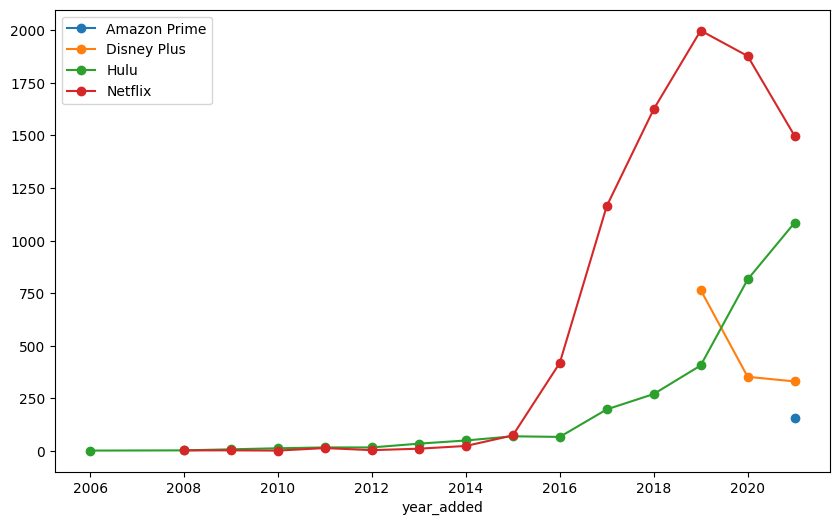

In [149]:
# line graph accross years of number of movies added per platform
result.plot(kind="line", marker='o', figsize=(10, 6))

### Quelle platforme a en moyenne des films avec des bonnes note ?

In [150]:
tv_shows.head(1)

,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,IMDb_sur_10,Rotten Tomatoes_sur_100
0,Breaking Bad,2008,18+,9.4/10,100/100,1,0,0,0,9.4,100


In [151]:
def get_IMDb_mean_by_platform(platform_column: str, tv_shows:pd.DataFrame, min_grade: float = None, verbose: bool = False) -> float:
    """Calculate the mean IMDb score for TV shows on a given platform.

    Args:
        platform_column (str): The column name indicating the platform (e.g., "Netflix").
        tv_shows (pd.DataFrame): The DataFrame containing TV show data.
        min_grade (float): The minimum grade to consider.
        verbose (bool): Whether to print additional information.

    Returns:
        float: The mean IMDb score for TV shows on the specified platform.
    """
    if min_grade is not None:
        tv_shows = tv_shows[tv_shows["IMDb_sur_10"] >= min_grade]
    value = tv_shows[tv_shows[platform_column] == 1]["IMDb_sur_10"].mean()/10*100
    if verbose:
        print(f"Moyenne des notes IMDb des séries sur {platform_column} : {value:.2f}/100")
    return value

def get_Rotten_Tomatoes_mean_by_platform(platform_column: str, tv_shows:pd.DataFrame, min_grade: float = None, verbose: bool = False) -> float:
    """Calculate the mean Rotten Tomatoes score for TV shows on a given platform.

    Args:
        platform_column (str): The column name indicating the platform (e.g., "Netflix").
        tv_shows (pd.DataFrame): The DataFrame containing TV show data.
        min_grade (float): The minimum grade to consider.
        verbose (bool): Whether to print additional information.
    Returns:
        float: The mean Rotten Tomatoes score for TV shows on the specified platform.
    """
    if min_grade is not None:
        tv_shows = tv_shows[tv_shows["Rotten Tomatoes_sur_100"] >= min_grade]
    value = tv_shows[tv_shows[platform_column] == 1]["Rotten Tomatoes_sur_100"].mean()
    if verbose:
        print(f"Moyenne des notes Rotten Tomatoes des séries sur {platform_column} : {value:.2f}/100")
    return value

In [152]:
result = pd.DataFrame(
    columns=["IMDb Mean", "Rotten Tomatoes Mean"]
)
for platform in ["Netflix", "Prime Video", "Disney+", "Hulu"]:
    IMDb_mean = get_IMDb_mean_by_platform(platform, tv_shows, verbose=True)
    Rotten_Tomatoes_mean = get_Rotten_Tomatoes_mean_by_platform(platform, tv_shows, verbose=True)
    result.loc[platform] = [IMDb_mean, Rotten_Tomatoes_mean]
display(result)

Moyenne des notes IMDb des séries sur Netflix : 71.11/100
Moyenne des notes Rotten Tomatoes des séries sur Netflix : 53.56/100
Moyenne des notes IMDb des séries sur Prime Video : 71.53/100
Moyenne des notes Rotten Tomatoes des séries sur Prime Video : 37.76/100
Moyenne des notes IMDb des séries sur Disney+ : 69.71/100
Moyenne des notes Rotten Tomatoes des séries sur Disney+ : 49.42/100
Moyenne des notes IMDb des séries sur Hulu : 70.82/100
Moyenne des notes Rotten Tomatoes des séries sur Hulu : 52.84/100


,IMDb Mean,Rotten Tomatoes Mean
Netflix,71.109333,53.559107
Prime Video,71.525381,37.761333
Disney+,69.711111,49.424501
Hulu,70.823695,52.837754


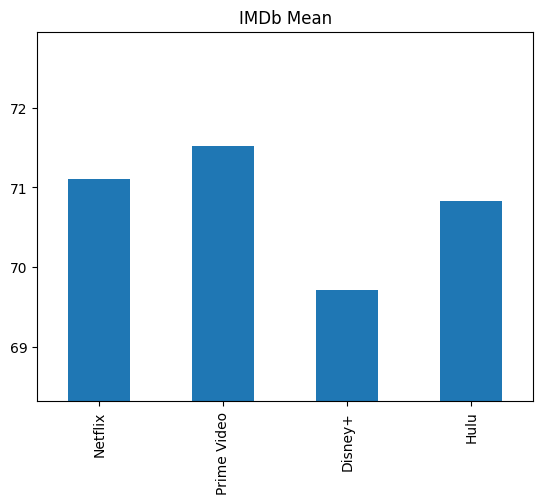

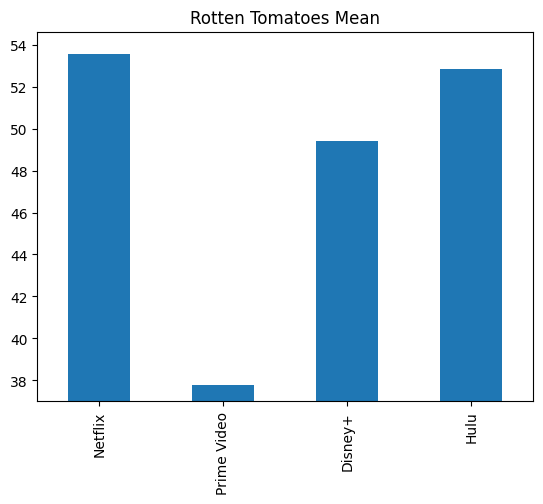

In [153]:
for col in result.columns:
    ax = result[col].plot(kind="bar", title=col)
    ax.set_ylim(
        bottom=result[col].min()* 0.98,
        top=result[col].max()* 1.02
    )
    plt.show()

In [154]:
export_to_json(result, filename="mean_tv_show_ratings_per_platform", include_index=True)

### nombre de top avis pour chaque platform

In [155]:
result

,IMDb Mean,Rotten Tomatoes Mean
Netflix,71.109333,53.559107
Prime Video,71.525381,37.761333
Disney+,69.711111,49.424501
Hulu,70.823695,52.837754


In [156]:
filtre_IMDb = 7
filtre_rotten = 70
filtered_tv_show_IMBd = tv_shows[tv_shows["IMDb_sur_10"] >= filtre_IMDb]
filtered_tv_show_rotten = tv_shows[tv_shows["Rotten Tomatoes_sur_100"] >= filtre_rotten]
result = pd.DataFrame(
    columns=["IMDb Count", "Rotten Tomatoes Count"],
)
for platform in ["Netflix", "Prime Video", "Disney+", "Hulu"]:
    IMDb_count = filtered_tv_show_IMBd[filtered_tv_show_IMBd[platform] == 1].shape[0]
    Rotten_Tomatoes_count = filtered_tv_show_rotten[filtered_tv_show_rotten[platform] == 1].shape[0]
    result.loc[platform, "IMDb Count"] = IMDb_count
    result.loc[platform, "Rotten Tomatoes Count"] = Rotten_Tomatoes_count

    # add percentage of good rated tv shows
    total_count = tv_shows[tv_shows[platform] == 1].shape[0]
    result.loc[platform, "IMDb Percentage"] = IMDb_count / total_count * 100
    result.loc[platform, "Rotten Tomatoes Percentage"] = Rotten_Tomatoes_count / total_count * 100

result.index.name = "Platform"
display(result)

,IMDb Count,Rotten Tomatoes Count,IMDb Percentage,Rotten Tomatoes Percentage
Platform,,,,
Netflix,1157,304,58.701167,15.423643
Prime Video,770,147,42.053523,8.028400
Disney+,166,29,47.293447,8.262108
Hulu,917,301,56.570019,18.568785


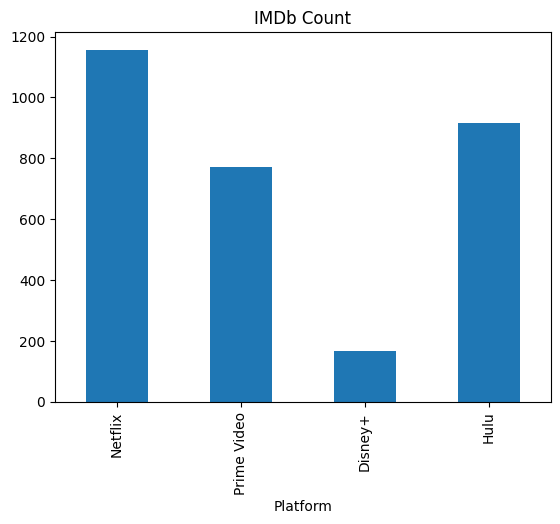

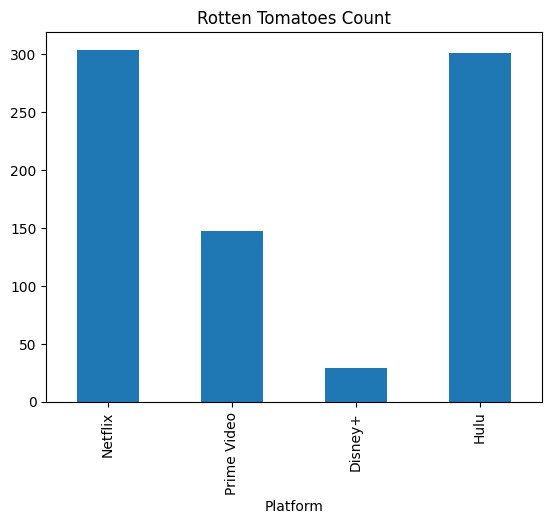

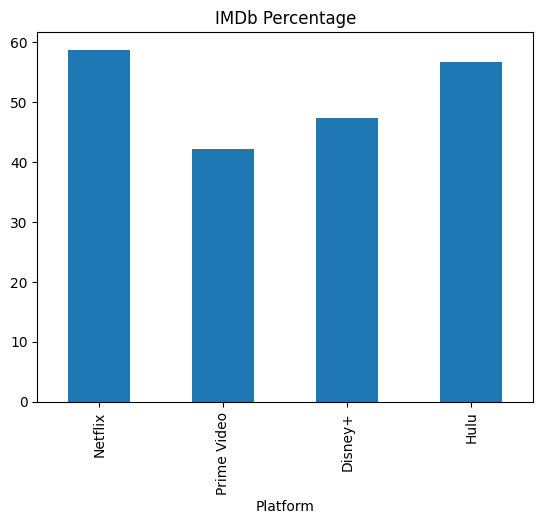

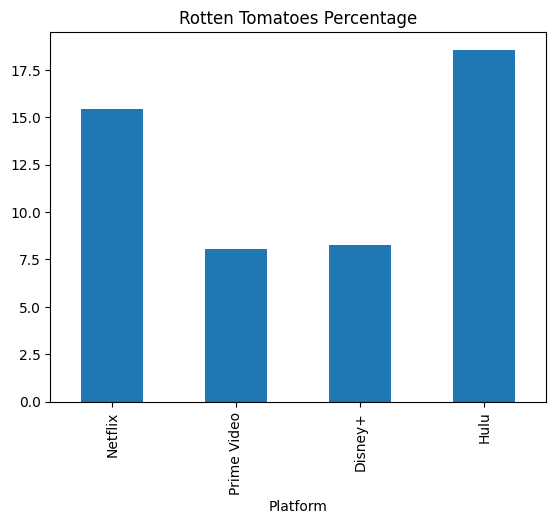

In [157]:
for col in result.columns:
    ax = result[col].plot(kind="bar", title=col)
    plt.show()

In [158]:
export_to_json(result, filename="count_and_percentage_tv_shows_above_threshold_per_platform", include_index=True)

### Présence par genre/pays dans les différentes platforme (Netflix est-elle diversifié comparé aux autres ?)

In [159]:
def groupby_country_platform(data: pd.DataFrame, platform_name: str, just_US: bool=False) -> pd.DataFrame:
    """the purpose of this function is to group the data by country and platform
    Args:
        data (pd.DataFrame): dataframe containing the data
        platform_name (str): name of the platform
        just_US (bool): if True, only USA VS the World is considered, otherwise all countries are considered
    Returns:
        pd.DataFrame: dataframe grouped by country with count and percentage columns
    """
    country_of_platform = f"country_{platform_name}"
    
    # explode the country column
    data_exploded_on_country = data.assign(**{country_of_platform: data['country'].str.split(', ')}).explode(country_of_platform)
    data_exploded_on_country[country_of_platform] = data_exploded_on_country[country_of_platform].str.strip()
    
    if just_US:
        # replace every country except USA by "Rest of the World"
        data_exploded_on_country[country_of_platform] = data_exploded_on_country[country_of_platform].apply(lambda x: x if x == "United States" else "Rest of the World")

    # group by country
    country_group = pd.DataFrame(data_exploded_on_country.groupby(country_of_platform).size().sort_values(ascending=False),columns=[f"{platform_name}_count"])
    # calculate percentage
    country_group[f"{platform_name}_percent"] = round(country_group[f"{platform_name}_count"] / country_group[f"{platform_name}_count"].sum() * 100, 4)
    
    if not just_US:
        # get top 10 countries and group the rest as "Other"
        country_group = country_group.head(10)
        country_group.loc["Autre"] = {
            f"{platform_name}_count": data_exploded_on_country.groupby(country_of_platform).size().sum() - country_group[f"{platform_name}_count"].sum(),
            f"{platform_name}_percent": 100 - country_group[f"{platform_name}_percent"].sum(),
        }
    return country_group

In [160]:
result_n = groupby_country_platform(netflix_titles, "Netflix").reset_index()
result_ap = groupby_country_platform(amazon_prime_titles, "Amazon Prime").reset_index()
result_dp = groupby_country_platform(disney_plus_titles, "Disney+").reset_index()
result_h = groupby_country_platform(hulu_titles, "Hulu").reset_index()

result = pd.concat([result_n, result_ap, result_dp, result_h], axis=1).fillna(0)
result

,country_Netflix,Netflix_count,Netflix_percent,country_Amazon Prime,Amazon Prime_count,Amazon Prime_percent,country_Disney+,Disney+_count,Disney+_percent,country_Hulu,Hulu_count,Hulu_percent
0,United States,3689,36.8384,United States,334,40.5340,United States,1184,77.4869,United States,1097,55.2367
1,India,1046,10.4454,India,246,29.8544,United Kingdom,101,6.6099,Japan,281,14.1490
2,United Kingdom,804,8.0288,United Kingdom,67,8.1311,Canada,77,5.0393,United Kingdom,200,10.0705
3,Canada,445,4.4438,Canada,35,4.2476,Australia,23,1.5052,Canada,88,4.4310
4,France,393,3.9245,France,20,2.4272,France,22,1.4398,Germany,41,2.0645
5,Japan,318,3.1756,Germany,17,2.0631,South Korea,13,0.8508,France,40,2.0141
6,Spain,232,2.3168,Italy,14,1.6990,China,10,0.6545,Australia,36,1.8127
7,South Korea,231,2.3068,Spain,11,1.3350,Japan,10,0.6545,Sweden,20,1.0070
8,Germany,226,2.2568,Japan,6,0.7282,Germany,9,0.5890,Denmark,17,0.8560
9,Mexico,169,1.6876,China,6,0.7282,Ireland,8,0.5236,South Korea,15,0.7553


In [161]:
export_to_json(result, filename="country_distribution_per_platform", include_index=False)

In [162]:
result_n = groupby_country_platform(netflix_titles, "Netflix", True)
result_ap = groupby_country_platform(amazon_prime_titles, "Amazon Prime", True)
result_dp = groupby_country_platform(disney_plus_titles, "Disney+", True)
result_h = groupby_country_platform(hulu_titles, "Hulu", True)

result = pd.concat([result_n, result_ap, result_dp, result_h], axis=1).fillna(0)
result

,Netflix_count,Netflix_percent,Amazon Prime_count,Amazon Prime_percent,Disney+_count,Disney+_percent,Hulu_count,Hulu_percent
Rest of the World,7156,65.9843,9486,96.5988,563,32.2267,2342,68.1012
United States,3689,34.0157,334,3.4012,1184,67.7733,1097,31.8988


In [163]:
result.rename(columns={
    "Netflix_count": "Netflixcount",
    "Amazon Prime_count": "AmazonPrime_count",
    "Disney+_count": "Disney_plus_count",
    "Hulu_count": "Hulucount",
    
    "Netflix_percent": "Netflixpercent",
    "Amazon Prime_percent": "AmazonPrime_percent",
    "Disney+_percent": "Disney_plus_percent",
    "Hulu_percent": "Hulupercent",
}, inplace=True)


In [164]:
export_to_json(result, filename="us_vs_world_distribution_per_platform", include_index=True)

#### Catégorie

In [165]:
# .loc[category_group.index.isin(columns)]
def groupby_category_platform(data: pd.DataFrame, platform_name: str, ) -> pd.DataFrame:
    column_name = f"category_{platform_name}"
    data_exploded_on_category = data.assign(**{column_name: data['listed_in'].str.split(', ')}).explode(column_name)
    data_exploded_on_category[column_name] = data_exploded_on_category[column_name].str.strip()
    category_group = pd.DataFrame(data_exploded_on_category.groupby(column_name).size().sort_values(ascending=False),columns=[f"{platform_name}_count"])
    category_group[f"{platform_name}_percent"] = category_group[f"{platform_name}_count"] / category_group[f"{platform_name}_count"].sum() * 100
    category_group = category_group.head(10)
    return category_group

In [166]:
result_n = groupby_category_platform(netflix_titles, "Netflix").reset_index()
result_ap = groupby_category_platform(amazon_prime_titles, "Amazon Prime").reset_index()
result_dp = groupby_category_platform(disney_plus_titles, "Disney+").reset_index()
result_h = groupby_category_platform(hulu_titles, "Hulu").reset_index()

result = pd.concat([result_n, result_ap, result_dp, result_h], axis=1).fillna(0).sort_values(by="Netflix_count", ascending=False)
result

,category_Netflix,Netflix_count,Netflix_percent,category_Amazon Prime,Amazon Prime_count,Amazon Prime_percent,category_Disney+,Disney+_count,Disney+_percent,category_Hulu,Hulu_count,Hulu_percent
0,International Movies,2752,14.242095,Drama,3687,20.137637,Family,632,16.163683,Drama,907,13.415175
1,Dramas,2427,12.560161,Comedy,2099,11.464307,Animation,542,13.861893,Comedy,667,9.865405
2,Comedies,1674,8.663251,Action,1657,9.050194,Comedy,526,13.452685,Adventure,556,8.223636
3,International TV Shows,1351,6.991668,Suspense,1501,8.198154,Action-Adventure,452,11.560102,Action,555,8.208845
4,Documentaries,869,4.497231,Kids,1085,5.926047,Animals & Nature,208,5.319693,Documentaries,524,7.750333
5,Action & Adventure,859,4.445479,Documentary,993,5.423562,Coming of Age,205,5.242967,Anime,329,4.866144
6,TV Dramas,763,3.948662,Special Interest,980,5.352559,Fantasy,192,4.910486,Horror,304,4.496376
7,Independent Movies,756,3.912436,Horror,875,4.779070,Documentary,174,4.450128,Reality,247,3.653306
8,Children & Family Movies,641,3.317290,Romance,674,3.681250,Kids,141,3.606138,Thriller,231,3.416654
9,Romantic Movies,616,3.187911,Animation,547,2.987602,Drama,134,3.427110,Crime,217,3.209584


In [167]:
export_to_json(result, "category_distribution_per_platform")

### Comment évolue le coût de production d’un court métrage/film/série kaggle : 

In [168]:
work = movies_dataset[["budget", "revenue", "year_release"]]
#work = work[(work["budget"] > 0) | (work["revenue"] > 0)]
work

,budget,revenue,year_release
index,,,
0,237000000.0,2.787965e+09,2009
1,300000000.0,9.610000e+08,2007
2,245000000.0,8.806746e+08,2015
3,250000000.0,1.084939e+09,2012
4,260000000.0,2.841391e+08,2012
...,...,...,...
4798,220000.0,2.040920e+06,1992
4799,9000.0,0.000000e+00,2011
4800,0.0,0.000000e+00,2013


In [169]:
groupby_work_budget = work[work["budget"] > 0].groupby("year_release").mean().sort_index()[["budget"]]
groupby_work_revenue = work[work["revenue"] > 0].groupby("year_release").mean().sort_index()[["revenue"]]
groupby_work = groupby_work_budget.merge(
    groupby_work_revenue,
    left_index=True,
    right_index=True,
    how="outer"
)
groupby_work_count = pd.DataFrame(work.groupby("year_release").size().sort_index(),columns=["count"])
groupby_work = groupby_work.merge(
    groupby_work_count,
    left_index=True,
    right_index=True,
    suffixes=("_mean", "_count")
)

In [170]:
groupby_work

,budget,revenue,count
year_release,,,
1916,3.859070e+05,8.394751e+06,1
1925,2.450000e+05,2.200000e+07,1
1927,1.261905e+06,2.240079e+06,1
1929,3.790000e+05,4.358000e+06,2
1930,3.950000e+06,8.000000e+06,1
...,...,...,...
2012,4.568417e+07,1.609447e+08,208
2013,4.435611e+07,1.436288e+08,231
2014,4.334384e+07,1.686748e+08,238


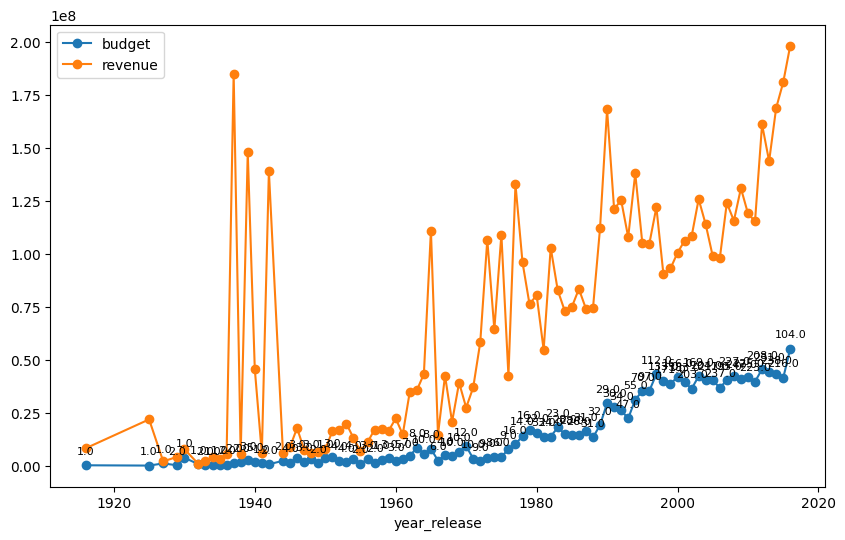

In [171]:

ax = groupby_work[["budget", "revenue"]].plot(
    kind="line",
    marker="o",
    figsize=(10, 6),
)
#label each point with its count value
for year, row in groupby_work.iterrows():
    ax.annotate(
        str(row["count"]),
        (year, row["budget"]),
        textcoords="offset points",
        xytext=(0, 8),
        ha="center",
        fontsize=8
    )

In [172]:
export_to_json(
    groupby_work,
    filename="average_budget_revenue_per_year",
    include_index=True,
    rename_columns={
        "year_release": "Year",
        "budget": "Average Budget",
        "revenue": "Average Revenue",
        "count": "Number of Movies"
    },
    comments="mean budget, et revenue des films qui ont un budget/revenue > 0, par année de sortie, le nombre de films par année (même ceux avec budget/revenue = 0), n'inclut pas les années qui ont des films avec budget/revenue > 0"
)